In [ ]:
# Installations and Imports
#!pip install wandb tensorflow scikit-learn opencv-python requests


In [29]:

import tensorflow as tf
import numpy as np
import wandb
from wandb.integration.keras import WandbCallback
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import sys
sys.path.append('..')
from model_training.data_loader import QuickDrawDataLoader
from model_training.model import create_cnn_model, compile_model
from model_training.config import MODEL_CONFIG, TRAIN_CONFIG, WANDB_CONFIG

print("All imports successful!")


All imports successful!


In [30]:
import os

# IMPORTANT: Remove your API key from code and use wandb login instead
# os.environ['WANDB_API_KEY'] = 'your-key-here'  # DON'T commit this!

os.environ['WANDB_NOTEBOOK_NAME'] = 'train_sketch_model.ipynb'

# Login to W&B
wandb.login()

print("W&B login successful!")

W&B login successful!


## Sketch Recognition - Model Training

This notebook trains a Custom CNN model on the Google QuickDraw dataset for sketch recognition.

### Prerequisites
1. **W&B Account**: Sign up at https://wandb.ai
2. **API Key**: Get from https://wandb.ai/authorize
3. **Update Config**: Set your W&B username in `model_training/config.py`

### Steps
1. Import libraries and configure W&B
2. Load QuickDraw dataset (20 categories)
3. Create and train CNN model
4. Evaluate performance
5. Save model for deployment

# Cell 2: Configure W&B

Before running the next cell, you need to:
1. Get your W&B API key from: https://wandb.ai/authorize
2. Run this cell to login

In [31]:
# Initialize W&B with minimal configuration

run = wandb.init(
    project='sketch-recognition',
    name='sketch-cnn-training'
)

print("W&B initialized!")
print(f"Dashboard: {run.get_url()}")

wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


W&B initialized!
Dashboard: https://wandb.ai/fhtw/sketch-recognition/runs/ij58utct


In [ ]:
# Load Data
print(" Loading QuickDraw data...")
data_loader = QuickDrawDataLoader()
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_loader.load_data()

print(f"Data loaded:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples")
print(f"   Test: {X_test.shape[0]} samples")
print(f"   Classes: {len(TRAIN_CONFIG['categories'])}")


📥 Loading QuickDraw data...
Loaded 10000 samples for apple
Loaded 10000 samples for apple
Loaded 10000 samples for banana
Loaded 10000 samples for cat
Loaded 10000 samples for banana
Loaded 10000 samples for cat
Loaded 10000 samples for dog
Loaded 10000 samples for house
Loaded 10000 samples for dog
Loaded 10000 samples for house
Loaded 10000 samples for tree
Loaded 10000 samples for tree
Loaded 10000 samples for car
Loaded 10000 samples for car
Loaded 10000 samples for fish
Loaded 10000 samples for fish
Loaded 10000 samples for bird
Loaded 10000 samples for bird
Loaded 10000 samples for clock
Loaded 10000 samples for book
Loaded 10000 samples for clock
Loaded 10000 samples for book
Loaded 10000 samples for chair
Loaded 10000 samples for cup
Loaded 10000 samples for chair
Loaded 10000 samples for cup
Loaded 10000 samples for star
Loaded 10000 samples for star
Error downloading heart: 404 Client Error: Not Found for url: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap

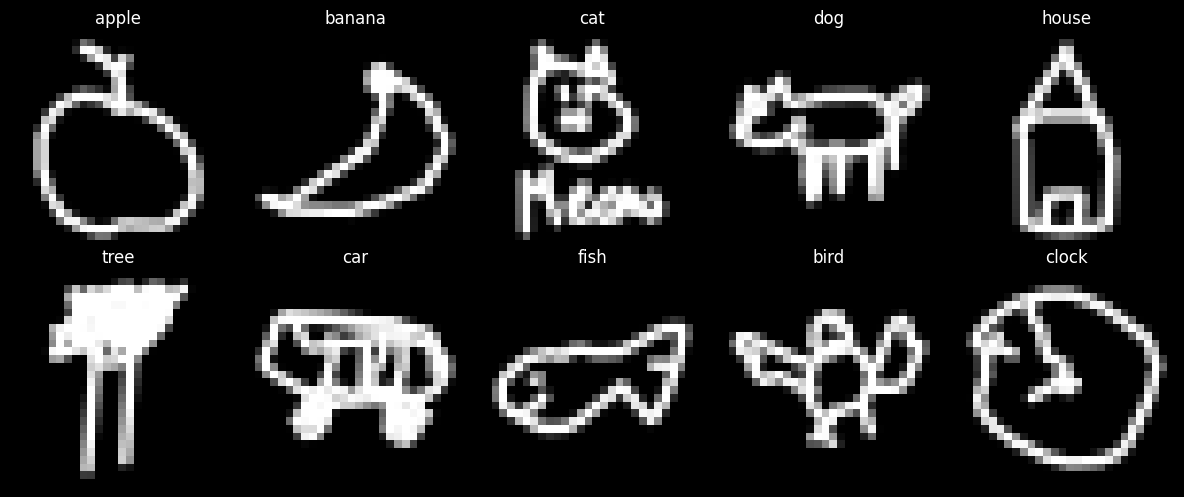

In [ ]:

# Visualize Sample Data
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    row, col = i // 5, i % 5
    sample_idx = np.where(y_train == i)[0][0]
    axes[row, col].imshow(X_train[sample_idx].squeeze(), cmap='gray')
    axes[row, col].set_title(TRAIN_CONFIG['categories'][i])
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# Log sample images to W&B
sample_images = []
for i in range(10):
    sample_idx = np.where(y_train == i)[0][0]
    sample_images.append(wandb.Image(X_train[sample_idx].squeeze(), 
                                   caption=TRAIN_CONFIG['categories'][i]))
wandb.log({"sample_sketches": sample_images})



In [ ]:
# Create and Compile Model
print(" Creating model...")
model = create_cnn_model()
model = compile_model(model, learning_rate=TRAIN_CONFIG['learning_rate'])

model.summary()



In [ ]:
#  Setup Callbacks
# Note: Removed WandbCallback due to compatibility issues - using manual logging instead
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    )
]

print("Callbacks configured (W&B will log metrics manually after training)")

Callbacks configured (W&B will log metrics manually after training)


In [ ]:
#  Train Model
print("🚀 Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=TRAIN_CONFIG['batch_size'],
    epochs=TRAIN_CONFIG['epochs'],
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

# Log training history to W&B
for epoch in range(len(history.history['loss'])):
    wandb.log({
        'epoch': epoch + 1,
        'loss': history.history['loss'][epoch],
        'accuracy': history.history['accuracy'][epoch],
        'val_loss': history.history['val_loss'][epoch],
        'val_accuracy': history.history['val_accuracy'][epoch]
    })

print("Training metrics logged to W&B")

🚀 Starting training...
Epoch 1/10
Epoch 1/10
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 112s 56ms/step - accuracy: 0.5789 - loss: 1.4241 - val_accuracy: 0.7869 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 2/10
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 112s 56ms/step - accuracy: 0.5789 - loss: 1.4241 - val_accuracy: 0.7869 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 2/10
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 102s 54ms/step - accuracy: 0.7408 - loss: 0.8811 - val_accuracy: 0.8272 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 3/10
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 102s 54ms/step - accuracy: 0.7408 - loss: 0.8811 - val_accuracy: 0.8272 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 3/10
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 108s 57ms/step - accuracy: 0.7728 - loss: 0.7727 - val_accuracy: 0.8449 - val_loss: 0.5146 - learning_rate: 0.0010
Epoch 4/10
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 108s 57ms/step - accuracy: 0.7728 - loss: 0.7727 - val_accuracy: 0.8449 - val_loss: 0.5146 - learning_rate: 0.0010
Epoch 4/10
1900/1900 ━━━

In [ ]:
# Evaluate Model
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Log final metrics to W&B
wandb.log({
    'final_accuracy': test_accuracy,
    'final_loss': test_loss,
    'best_val_accuracy': max(history.history['val_accuracy'])
})



Evaluating model...
Test Accuracy: 0.8746
Test Loss: 0.4159
Test Accuracy: 0.8746
Test Loss: 0.4159


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Classification Report:
              precision    recall  f1-score   support

       apple       0.95      0.96      0.95      2000
      banana       0.85      0.83      0.84      2000
         cat       0.84      0.74      0.79      2000
         dog       0.69      0.72      0.70      2000
       house       0.97      0.94      0.96      2000
        tree       0.91      0.91      0.91      2000
         car       0.92      0.92      0.92      2000
        fish       0.91      0.90      0.90      2000
        bird       0.74      0.73      0.74      2000
       clock       0.95      0.93      0.94      2000
        book       0.92      0.90      0.91      2000
       chair       0.89      0.92      0.90      2000
         cup       0.85      0.89      0.87      2000
        star       0.90      0.94      0.92      2000
 smiley face       0.93      0.92      0.92      2000
         sun       0.92   

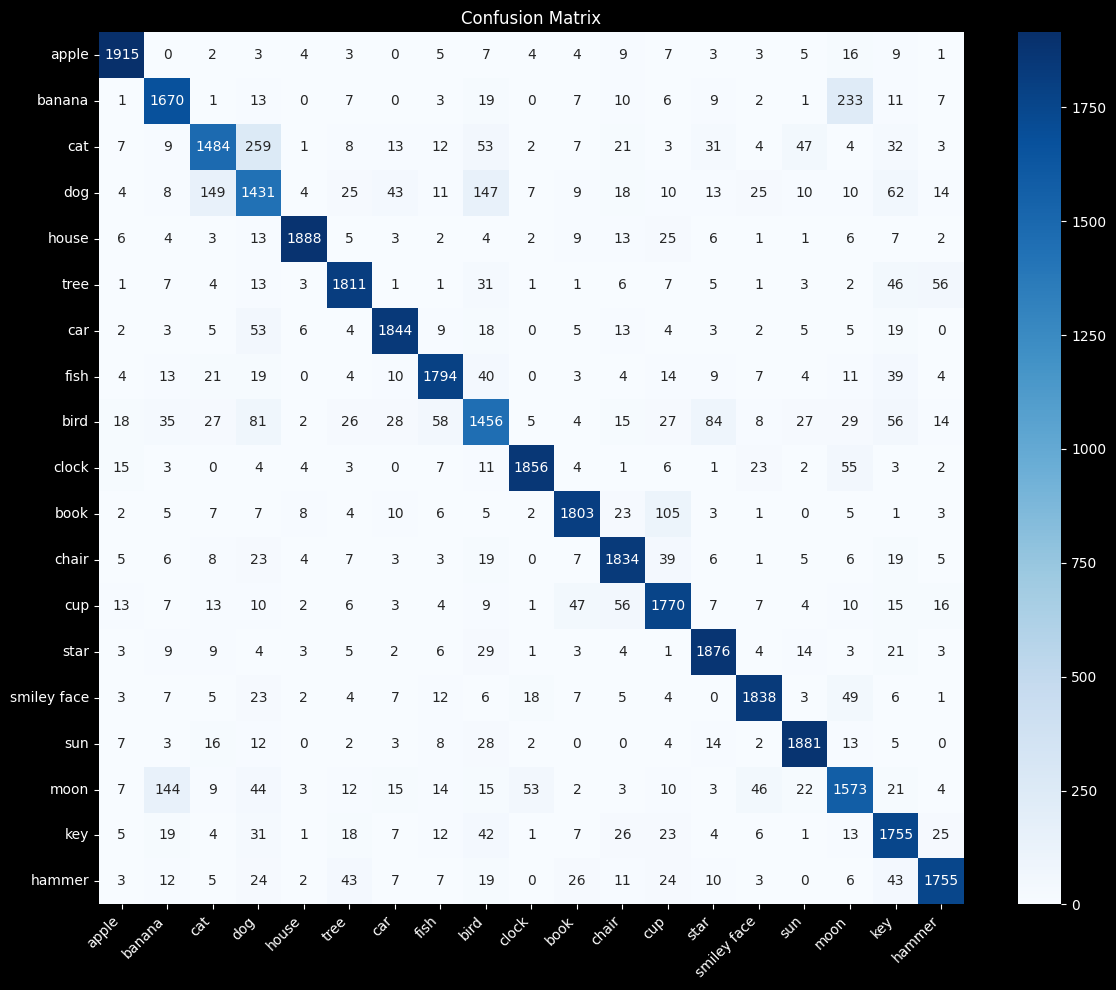

Error: You must call wandb.init() before wandb.log()

In [ ]:
# Generate Predictions and Detailed Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes present in test set
unique_classes = np.unique(np.concatenate([y_test, y_pred_classes]))
target_names_filtered = [TRAIN_CONFIG['categories'][i] for i in unique_classes]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, 
                          labels=unique_classes,
                          target_names=target_names_filtered))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_filtered,
            yticklabels=target_names_filtered)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Log confusion matrix to W&B
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_test,
    preds=y_pred_classes,
    class_names=TRAIN_CONFIG['categories']
)})

In [39]:
# Cell 10: Save Model
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save model
model_path = '../models/sketch_model.h5'
model.save(model_path)
print(f"Model saved to: {model_path}")

# Also save to W&B as an artifact
artifact = wandb.Artifact('sketch_model', type='model')
artifact.add_file(model_path)
run.log_artifact(artifact)
print("Model uploaded to W&B as artifact")

Model saved to: ../models/sketch_model.h5
Model uploaded to W&B as artifact
Model uploaded to W&B as artifact


In [ ]:
# Test Inference
import sys
sys.path.append('..')
from deployment.inference import SketchPredictor

# Test with the saved model
predictor = SketchPredictor('../models/sketch_model.h5')

# Test with a random sample
sample_idx = 42
test_image = X_test[sample_idx].squeeze() * 255
true_label = TRAIN_CONFIG['categories'][y_test[sample_idx]]

predictions = predictor.predict(test_image)

print(f"Inference Test:")
print(f"   True label: {true_label}")
print(f"   Top predictions:")
for i, pred in enumerate(predictions, 1):
    print(f"   {i}. {pred['category']}: {pred['confidence']:.2f}%")

Inference Test:
   True label: car
   Top predictions:
   1. moon: 25.40%
   2. dog: 15.60%
   3. tree: 14.10%


In [ ]:
# Finish W&B Run
wandb.finish()
print("All done! Model trained and saved successfully!")

wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


All done! Model trained and saved successfully!
